Import the MicroGP package (first install it: ``!pip install microgp``)


In [15]:
import sys
import microgp as ugp
ugp.logging.DefaultLogger.setLevel(level=ugp.logging.INFO)

### Creation of the individuals structure
Define parameters

In [16]:
reg_alternatives = ['%eax', '%ebx', '%ecx', '%edx']
reg_param = ugp.make_parameter(ugp.parameter.Categorical, alternatives=reg_alternatives)
instr_alternatives = ['add', 'sub', 'and', 'or', 'xor', 'cmp']
instr_param = ugp.make_parameter(ugp.parameter.Categorical, alternatives=instr_alternatives)
shift_alternatives = ['shr', 'shl']
shift_param = ugp.make_parameter(ugp.parameter.Categorical, alternatives=shift_alternatives)
jmp_alternatives = ['ja', 'jz', 'jnz', 'je', 'jne', 'jc', 'jnc', 'jo', 'jno', 'jmp']
jmp_instructions = ugp.make_parameter(ugp.parameter.Categorical, alternatives=jmp_alternatives)
integer = ugp.make_parameter(ugp.parameter.Integer, min=-32768, max=32767)
int8 = ugp.make_parameter(ugp.parameter.Integer, min=0, max=256)
jmp_target = ugp.make_parameter(ugp.parameter.LocalReference,
                                allow_self=False,
                                allow_forward=True,
                                allow_backward=False,
                                frames_up=0)

Define the macros

In [17]:
jmp1 = ugp.Macro("    {jmp_instr} {jmp_ref}", {'jmp_instr': jmp_instructions, 'jmp_ref': jmp_target})
instr_op_macro = ugp.Macro("    {instr} {regS}, {regD}",{'instr': instr_param, 'regS': reg_param, 'regD': reg_param})
shift_op_macro = ugp.Macro("    {shift} ${int8}, {regD}", {'shift': shift_param, 'int8': int8, 'regD': reg_param})
prologue_macro = ugp.Macro('    .file   "solution.c"\n' +
                           '    .text\n' +
                           '    .globl  _darwin\n' +
                           '    .def    _darwin;        .scl    2;      .type   32;     .endef\n' +
                           '_darwin:\n' +
                           'LFB17:\n' +
                           '    .cfi_startproc\n' +
                           '    pushl   %ebp\n' +
                           '    .cfi_def_cfa_offset 8\n' +
                           '    .cfi_offset 5, -8\n' +
                           '    movl    %esp, %ebp\n' +
                           '    .cfi_def_cfa_register 5\n')
init_macro = ugp.Macro("    movl	${int_a}, %eax\n" +
                       "    movl	${int_b}, %ebx\n" +
                       "    movl	${int_c}, %ecx\n" +
                       "    movl	${int_d}, %edx\n",
                       {'int_a': integer, 'int_b': integer, 'int_c': integer, 'int_d': integer})
epilogue_macro = ugp.Macro(
    '    movl	%eax, -4(%ebp)\n' +
    '    movl	-4(%ebp), %eax\n' +
    '    leave\n' +
    '    .cfi_restore 5\n' +
    '    .cfi_def_cfa 4, 4\n' +
    '    ret\n' +
    '    .cfi_endproc\n' +
    'LFE17:\n' +
    '   .ident  "GCC: (MinGW.org GCC-8.2.0-5) 8.2.0"\n')

Define section

In [18]:
sec1 = ugp.make_section({jmp1, instr_op_macro, shift_op_macro}, size=(1, 50))

Create an instruction library

In [20]:
library = ugp.Constraints(file_name="solution{id}.s")

Define the sections in the library

In [21]:
library['main'] = [prologue_macro, init_macro, sec1, epilogue_macro]

### Define the evaluator script and the fitness type

In [22]:
if sys.platform != "win32":
    exit(-1)
else:
    script = "eval.bat"
library.evaluator = ugp.fitness.make_evaluator(evaluator=script, fitness_type=ugp.fitness.Lexicographic)

Define and set a property. It checks whether the section 'sec1' has or not the same number of 'shr' and 'shl'

In [23]:
def shift_count(individual, frame, **kk):
    from microgp.individual import get_nodes_in_frame
    shl_count = 0
    shr_count = 0
    nodes = get_nodes_in_frame(individual, frame)
    for node in nodes:
        parameters = individual.nodes[node]['parameters']
        if 'shift' in parameters.keys():
            if parameters['shift'].value == 'shr':
                shr_count += 1
            elif parameters['shift'].value == 'shl':
                shl_count += 1
    return {'shl_count': shl_count, 'shr_count': shr_count}

sec1.properties.add_base_builder(shift_count)
sec1.properties.add_checker(lambda shl_count, shr_count, **v: shl_count == shr_count)

### Create a list of operators with their aritiy

In [24]:
operators = ugp.Operators()

Add initialization operators

In [25]:
operators += ugp.GenOperator(ugp.create_random_individual, 0)

Add mutation operators

In [26]:
operators += ugp.GenOperator(ugp.hierarchical_mutation, 1)
operators += ugp.GenOperator(ugp.flat_mutation, 1)
operators += ugp.GenOperator(ugp.add_node_mutation, 1)
operators += ugp.GenOperator(ugp.remove_node_mutation, 1)

Add crossover operators

In [27]:
operators += ugp.GenOperator(ugp.macro_pool_one_cut_point_crossover, 2)
operators += ugp.GenOperator(ugp.macro_pool_uniform_crossover, 2)

Create the object that will manage the evolution

In [28]:
mu = 10
nu = 20
sigma = 0.7
lambda_ = 7
max_age = 10

darwin = ugp.Darwin(
    constraints=library,
    operators=operators,
    mu=mu,
    nu=nu,
    lambda_=lambda_,
    sigma=sigma,
    max_age=max_age,
)

Evolve (create random individuals and use selected genetic operators to evolve them)

In [29]:
darwin.evolve()

M:\LuBa\Documenti\GitHub\microgp4\src\microgp\parameter\helpers.py:64: RuntimeWarning: invalid value encountered in true_divide
  probs = probs / sum(probs)


Print best individuals, and their graph

16:26:01 These are the best ever individuals:
16:26:01     .file   "solution.c"
16:26:01     .text
16:26:01     .globl  _darwin
16:26:01     .def    _darwin;        .scl    2;      .type   32;     .endef
16:26:01 _darwin:
16:26:01 LFB17:
16:26:01     .cfi_startproc
16:26:01     pushl   %ebp
16:26:01     .cfi_def_cfa_offset 8
16:26:01     .cfi_offset 5, -8
16:26:01     movl    %esp, %ebp
16:26:01     .cfi_def_cfa_register 5
16:26:01 
16:26:01     movl	$-22690, %eax
16:26:01     movl	$-18761, %ebx
16:26:01     movl	$31143, %ecx
16:26:01     movl	$812, %edx
16:26:01 
16:26:01     jnz n9
16:26:01     jnz n28
16:26:01     sub %ecx, %eax
16:26:01     shl $69, %eax
16:26:01     jnz n21
16:26:01     shr $197, %ecx
16:26:01 n9:
16:26:01     and %eax, %edx
16:26:01     shl $89, %ecx
16:26:01     jnz n15
16:26:01     jno n31
16:26:01     ja n37
16:26:01     add %edx, %ecx
16:26:01 n15:
16:26:01     shl $228, %ecx
16:26:01     or %ebx, %eax
16:26:01     shr $47, %edx
16:26:01     add %eax, %ecx
16

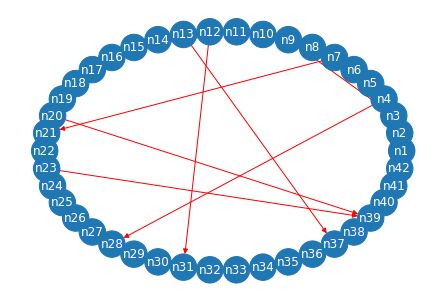

16:26:02 Fitness score: Lexicographic(32)

16:26:02     .file   "solution.c"
16:26:02     .text
16:26:02     .globl  _darwin
16:26:02     .def    _darwin;        .scl    2;      .type   32;     .endef
16:26:02 _darwin:
16:26:02 LFB17:
16:26:02     .cfi_startproc
16:26:02     pushl   %ebp
16:26:02     .cfi_def_cfa_offset 8
16:26:02     .cfi_offset 5, -8
16:26:02     movl    %esp, %ebp
16:26:02     .cfi_def_cfa_register 5
16:26:02 
16:26:02     movl	$-19651, %eax
16:26:02     movl	$20050, %ebx
16:26:02     movl	$-8468, %ecx
16:26:02     movl	$35, %edx
16:26:02 
16:26:02     jnz n9
16:26:02     jnz n28
16:26:02     sub %ebx, %eax
16:26:02     shl $69, %eax
16:26:02     jnz n21
16:26:02     shr $197, %ecx
16:26:02 n9:
16:26:02     and %eax, %edx
16:26:02     shl $89, %ecx
16:26:02     jnz n15
16:26:02     jno n31
16:26:02     ja n37
16:26:02     add %edx, %ecx
16:26:02 n15:
16:26:02     shl $228, %ecx
16:26:02     or %ebx, %eax
16:26:02     shr $47, %edx
16:26:02     add %eax, %ecx
16:26:0

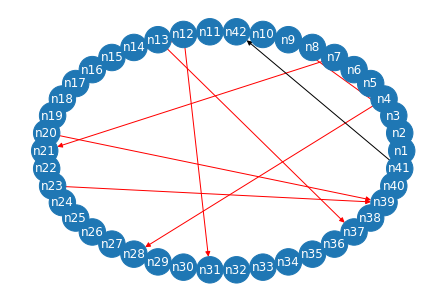

16:26:02 Fitness score: Lexicographic(32)

16:26:02     .file   "solution.c"
16:26:02     .text
16:26:02     .globl  _darwin
16:26:02     .def    _darwin;        .scl    2;      .type   32;     .endef
16:26:02 _darwin:
16:26:02 LFB17:
16:26:02     .cfi_startproc
16:26:02     pushl   %ebp
16:26:02     .cfi_def_cfa_offset 8
16:26:02     .cfi_offset 5, -8
16:26:02     movl    %esp, %ebp
16:26:02     .cfi_def_cfa_register 5
16:26:02 
16:26:02     movl	$-19651, %eax
16:26:02     movl	$20050, %ebx
16:26:02     movl	$-8468, %ecx
16:26:02     movl	$35, %edx
16:26:02 
16:26:02     jmp n9
16:26:02     jnz n28
16:26:02     sub %ebx, %eax
16:26:02     shl $69, %eax
16:26:02     jnz n21
16:26:02     shr $197, %ecx
16:26:02 n9:
16:26:02     and %eax, %edx
16:26:02     shl $89, %ecx
16:26:02     jnz n15
16:26:02     jno n33
16:26:02     ja n39
16:26:02     add %edx, %ecx
16:26:02 n15:
16:26:02     shl $228, %ecx
16:26:02     or %ebx, %eax
16:26:02     shr $47, %edx
16:26:02     add %eax, %ecx
16:26:0

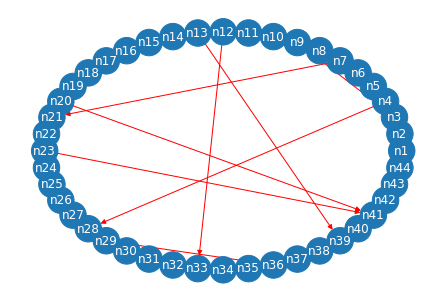

16:26:03 Fitness score: Lexicographic(32)

16:26:03     .file   "solution.c"
16:26:03     .text
16:26:03     .globl  _darwin
16:26:03     .def    _darwin;        .scl    2;      .type   32;     .endef
16:26:03 _darwin:
16:26:03 LFB17:
16:26:03     .cfi_startproc
16:26:03     pushl   %ebp
16:26:03     .cfi_def_cfa_offset 8
16:26:03     .cfi_offset 5, -8
16:26:03     movl    %esp, %ebp
16:26:03     .cfi_def_cfa_register 5
16:26:03 
16:26:03     movl	$-19651, %eax
16:26:03     movl	$20050, %ebx
16:26:03     movl	$-8468, %ecx
16:26:03     movl	$35, %edx
16:26:03 
16:26:03     jnz n9
16:26:03     jnz n28
16:26:03     sub %ebx, %eax
16:26:03     shl $69, %eax
16:26:03     jnz n21
16:26:03     shr $197, %ecx
16:26:03 n9:
16:26:03     and %eax, %edx
16:26:03     shl $89, %ecx
16:26:03     jnz n15
16:26:03     jno n31
16:26:03     ja n37
16:26:03     add %edx, %ecx
16:26:03 n15:
16:26:03     shl $228, %ecx
16:26:03     or %ebx, %eax
16:26:03     shr $47, %edx
16:26:03     add %eax, %ecx
16:26:0

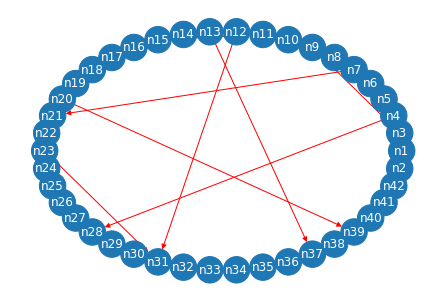

16:26:04 Fitness score: Lexicographic(32)

16:26:04     .file   "solution.c"
16:26:04     .text
16:26:04     .globl  _darwin
16:26:04     .def    _darwin;        .scl    2;      .type   32;     .endef
16:26:04 _darwin:
16:26:04 LFB17:
16:26:04     .cfi_startproc
16:26:04     pushl   %ebp
16:26:04     .cfi_def_cfa_offset 8
16:26:04     .cfi_offset 5, -8
16:26:04     movl    %esp, %ebp
16:26:04     .cfi_def_cfa_register 5
16:26:04 
16:26:04     movl	$-22690, %eax
16:26:04     movl	$-18761, %ebx
16:26:04     movl	$31143, %ecx
16:26:04     movl	$812, %edx
16:26:04 
16:26:04     jnz n9
16:26:04     jnz n28
16:26:04     sub %ebx, %eax
16:26:04     shl $69, %eax
16:26:04     jnz n21
16:26:04     shr $197, %ecx
16:26:04 n9:
16:26:04     and %eax, %edx
16:26:04     shl $89, %ecx
16:26:04     jnz n15
16:26:04     jno n31
16:26:04     ja n37
16:26:04     add %edx, %ecx
16:26:04 n15:
16:26:04     shl $228, %ecx
16:26:04     or %ebx, %eax
16:26:04     shr $47, %edx
16:26:04     add %eax, %ebx
16:26

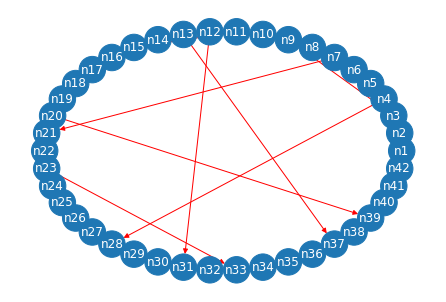

16:26:04 Fitness score: Lexicographic(32)

16:26:04     .file   "solution.c"
16:26:04     .text
16:26:04     .globl  _darwin
16:26:04     .def    _darwin;        .scl    2;      .type   32;     .endef
16:26:04 _darwin:
16:26:04 LFB17:
16:26:04     .cfi_startproc
16:26:04     pushl   %ebp
16:26:04     .cfi_def_cfa_offset 8
16:26:04     .cfi_offset 5, -8
16:26:04     movl    %esp, %ebp
16:26:04     .cfi_def_cfa_register 5
16:26:04 
16:26:04     movl	$-22690, %eax
16:26:04     movl	$-18761, %ebx
16:26:04     movl	$31143, %ecx
16:26:04     movl	$812, %edx
16:26:04 
16:26:04     jnz n9
16:26:04     jnz n28
16:26:04     sub %ebx, %eax
16:26:04     shl $69, %eax
16:26:04     jnz n21
16:26:04     shr $197, %ecx
16:26:04 n9:
16:26:04     and %eax, %edx
16:26:04     shl $89, %ecx
16:26:04     jnz n15
16:26:04     jno n31
16:26:04     ja n37
16:26:04     add %edx, %ecx
16:26:04 n15:
16:26:04     shl $228, %ecx
16:26:04     or %ebx, %eax
16:26:04     shr $47, %edx
16:26:04     add %eax, %ecx
16:26

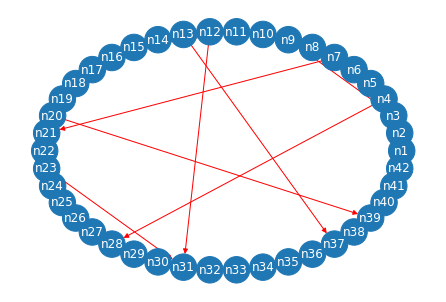

16:26:05 Fitness score: Lexicographic(32)

16:26:05     .file   "solution.c"
16:26:05     .text
16:26:05     .globl  _darwin
16:26:05     .def    _darwin;        .scl    2;      .type   32;     .endef
16:26:05 _darwin:
16:26:05 LFB17:
16:26:05     .cfi_startproc
16:26:05     pushl   %ebp
16:26:05     .cfi_def_cfa_offset 8
16:26:05     .cfi_offset 5, -8
16:26:05     movl    %esp, %ebp
16:26:05     .cfi_def_cfa_register 5
16:26:05 
16:26:05     movl	$-22690, %eax
16:26:05     movl	$-18761, %ebx
16:26:05     movl	$31143, %ecx
16:26:05     movl	$812, %edx
16:26:05 
16:26:05     jnz n9
16:26:05     jnz n28
16:26:05     sub %ebx, %eax
16:26:05     shl $69, %eax
16:26:05     jnz n21
16:26:05     shr $197, %ecx
16:26:05 n9:
16:26:05     and %eax, %edx
16:26:05     shl $89, %ecx
16:26:05     jnz n15
16:26:05     jno n31
16:26:05     ja n37
16:26:05     add %edx, %ecx
16:26:05 n15:
16:26:05     shl $228, %ecx
16:26:05     or %ebx, %eax
16:26:05     shr $47, %edx
16:26:05     add %eax, %ecx
16:26

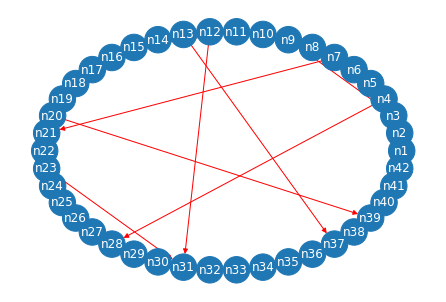

16:26:05 Fitness score: Lexicographic(32)

16:26:05     .file   "solution.c"
16:26:05     .text
16:26:05     .globl  _darwin
16:26:05     .def    _darwin;        .scl    2;      .type   32;     .endef
16:26:05 _darwin:
16:26:05 LFB17:
16:26:05     .cfi_startproc
16:26:05     pushl   %ebp
16:26:05     .cfi_def_cfa_offset 8
16:26:05     .cfi_offset 5, -8
16:26:05     movl    %esp, %ebp
16:26:05     .cfi_def_cfa_register 5
16:26:05 
16:26:05     movl	$-22690, %eax
16:26:05     movl	$-18761, %ebx
16:26:05     movl	$31143, %ecx
16:26:05     movl	$812, %edx
16:26:05 
16:26:05     jnz n9
16:26:05     jnz n28
16:26:05     sub %ebx, %eax
16:26:05     shl $69, %eax
16:26:05     jnz n21
16:26:05     shr $197, %ecx
16:26:05 n9:
16:26:05     and %eax, %edx
16:26:05     shl $89, %ecx
16:26:05     jnz n15
16:26:05     jno n31
16:26:05     ja n37
16:26:05     add %edx, %ecx
16:26:05 n15:
16:26:05     shl $228, %ecx
16:26:05     or %ebx, %eax
16:26:05     shr $47, %edx
16:26:05     add %eax, %ecx
16:26

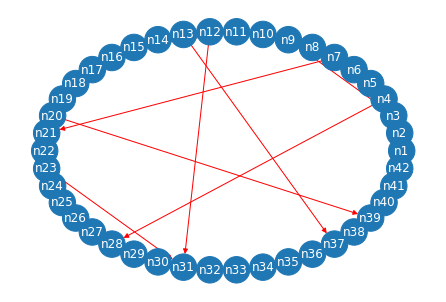

16:26:06 Fitness score: Lexicographic(32)

16:26:06     .file   "solution.c"
16:26:06     .text
16:26:06     .globl  _darwin
16:26:06     .def    _darwin;        .scl    2;      .type   32;     .endef
16:26:06 _darwin:
16:26:06 LFB17:
16:26:06     .cfi_startproc
16:26:06     pushl   %ebp
16:26:06     .cfi_def_cfa_offset 8
16:26:06     .cfi_offset 5, -8
16:26:06     movl    %esp, %ebp
16:26:06     .cfi_def_cfa_register 5
16:26:06 
16:26:06     movl	$-22690, %eax
16:26:06     movl	$-18761, %ebx
16:26:06     movl	$31143, %ecx
16:26:06     movl	$812, %edx
16:26:06 
16:26:06     jnz n9
16:26:06     jnz n28
16:26:06     sub %ebx, %eax
16:26:06     shl $69, %eax
16:26:06     jnz n21
16:26:06     shr $197, %ecx
16:26:06 n9:
16:26:06     and %eax, %edx
16:26:06     shl $89, %ecx
16:26:06     jnz n15
16:26:06     jno n31
16:26:06     ja n36
16:26:06     add %edx, %ecx
16:26:06 n15:
16:26:06     shl $228, %ecx
16:26:06     or %ebx, %eax
16:26:06     shr $47, %edx
16:26:06     add %eax, %ecx
16:26

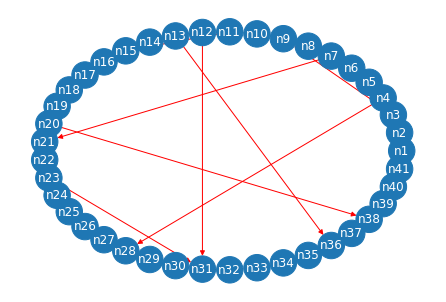

16:26:07 Fitness score: Lexicographic(32)

16:26:07     .file   "solution.c"
16:26:07     .text
16:26:07     .globl  _darwin
16:26:07     .def    _darwin;        .scl    2;      .type   32;     .endef
16:26:07 _darwin:
16:26:07 LFB17:
16:26:07     .cfi_startproc
16:26:07     pushl   %ebp
16:26:07     .cfi_def_cfa_offset 8
16:26:07     .cfi_offset 5, -8
16:26:07     movl    %esp, %ebp
16:26:07     .cfi_def_cfa_register 5
16:26:07 
16:26:07     movl	$-22690, %eax
16:26:07     movl	$-18761, %ebx
16:26:07     movl	$31143, %ecx
16:26:07     movl	$812, %edx
16:26:07 
16:26:07     jnz n10
16:26:07     jnz n30
16:26:07     sub %ecx, %ebx
16:26:07     sub %ebx, %eax
16:26:07     shl $69, %eax
16:26:07     jnz n22
16:26:07     shr $197, %ecx
16:26:07 n10:
16:26:07     and %eax, %edx
16:26:07     shl $89, %ecx
16:26:07     jnz n16
16:26:07     jno n33
16:26:07     ja n40
16:26:07     add %edx, %ecx
16:26:07 n16:
16:26:07     shl $228, %ecx
16:26:07     or %ebx, %eax
16:26:07     shr $47, %edx
16:

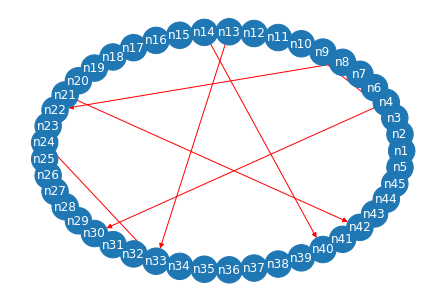

16:26:07 Fitness score: Lexicographic(32)

16:26:07     .file   "solution.c"
16:26:07     .text
16:26:07     .globl  _darwin
16:26:07     .def    _darwin;        .scl    2;      .type   32;     .endef
16:26:07 _darwin:
16:26:07 LFB17:
16:26:07     .cfi_startproc
16:26:07     pushl   %ebp
16:26:07     .cfi_def_cfa_offset 8
16:26:07     .cfi_offset 5, -8
16:26:07     movl    %esp, %ebp
16:26:07     .cfi_def_cfa_register 5
16:26:07 
16:26:07     movl	$-19651, %eax
16:26:07     movl	$20050, %ebx
16:26:07     movl	$-8468, %ecx
16:26:07     movl	$35, %edx
16:26:07 
16:26:07     jnz n9
16:26:07     jnz n28
16:26:07     sub %ecx, %eax
16:26:07     shl $69, %eax
16:26:07     jnz n21
16:26:07     shr $197, %ecx
16:26:07 n9:
16:26:07     and %eax, %edx
16:26:07     shl $89, %ecx
16:26:07     jnz n15
16:26:07     jno n31
16:26:07     ja n37
16:26:07     add %edx, %ecx
16:26:07 n15:
16:26:07     shl $228, %ecx
16:26:07     or %ebx, %eax
16:26:07     shr $47, %edx
16:26:07     add %eax, %ecx
16:26:0

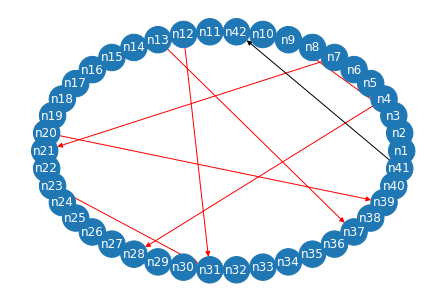

16:26:08 Fitness score: Lexicographic(32)

16:26:08     .file   "solution.c"
16:26:08     .text
16:26:08     .globl  _darwin
16:26:08     .def    _darwin;        .scl    2;      .type   32;     .endef
16:26:08 _darwin:
16:26:08 LFB17:
16:26:08     .cfi_startproc
16:26:08     pushl   %ebp
16:26:08     .cfi_def_cfa_offset 8
16:26:08     .cfi_offset 5, -8
16:26:08     movl    %esp, %ebp
16:26:08     .cfi_def_cfa_register 5
16:26:08 
16:26:08     movl	$-19651, %eax
16:26:08     movl	$20050, %ebx
16:26:08     movl	$-8468, %ecx
16:26:08     movl	$35, %edx
16:26:08 
16:26:08     jnz n9
16:26:08     jnz n30
16:26:08     sub %ebx, %eax
16:26:08     shl $69, %eax
16:26:08     jnz n22
16:26:08     shr $197, %ecx
16:26:08 n9:
16:26:08     and %eax, %edx
16:26:08     xor %ebx, %eax
16:26:08     shl $89, %ecx
16:26:08     jnz n16
16:26:08     jno n33
16:26:08     ja n39
16:26:08     add %edx, %ecx
16:26:08 n16:
16:26:08     shl $228, %ecx
16:26:08     or %ebx, %eax
16:26:08     shr $47, %edx
16:26:0

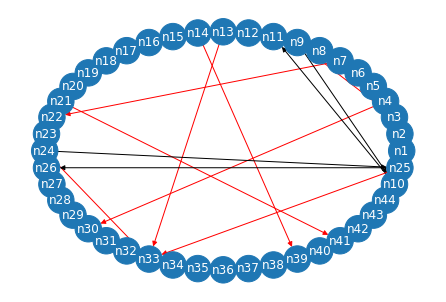

16:26:09 Fitness score: Lexicographic(32)

16:26:09     .file   "solution.c"
16:26:09     .text
16:26:09     .globl  _darwin
16:26:09     .def    _darwin;        .scl    2;      .type   32;     .endef
16:26:09 _darwin:
16:26:09 LFB17:
16:26:09     .cfi_startproc
16:26:09     pushl   %ebp
16:26:09     .cfi_def_cfa_offset 8
16:26:09     .cfi_offset 5, -8
16:26:09     movl    %esp, %ebp
16:26:09     .cfi_def_cfa_register 5
16:26:09 
16:26:09     movl	$-19651, %eax
16:26:09     movl	$20050, %ebx
16:26:09     movl	$-8468, %ecx
16:26:09     movl	$35, %edx
16:26:09 
16:26:09     jnz n9
16:26:09     jnz n28
16:26:09     sub %ecx, %eax
16:26:09     shl $69, %eax
16:26:09     jnz n21
16:26:09     shr $197, %ecx
16:26:09 n9:
16:26:09     and %eax, %edx
16:26:09     shl $89, %ecx
16:26:09     jnz n15
16:26:09     jno n31
16:26:09     ja n37
16:26:09     add %edx, %ecx
16:26:09 n15:
16:26:09     shl $228, %ecx
16:26:09     or %ebx, %eax
16:26:09     shr $47, %edx
16:26:09     add %eax, %ecx
16:26:0

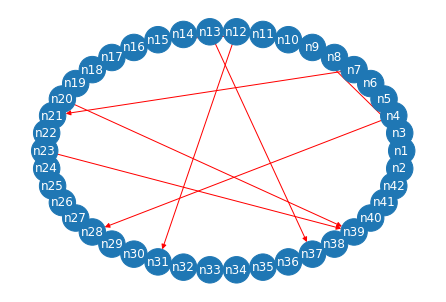

16:26:09 Fitness score: Lexicographic(32)

16:26:09     .file   "solution.c"
16:26:09     .text
16:26:09     .globl  _darwin
16:26:09     .def    _darwin;        .scl    2;      .type   32;     .endef
16:26:09 _darwin:
16:26:09 LFB17:
16:26:09     .cfi_startproc
16:26:09     pushl   %ebp
16:26:09     .cfi_def_cfa_offset 8
16:26:09     .cfi_offset 5, -8
16:26:09     movl    %esp, %ebp
16:26:09     .cfi_def_cfa_register 5
16:26:09 
16:26:09     movl	$-22690, %eax
16:26:09     movl	$-18761, %ebx
16:26:09     movl	$31143, %ecx
16:26:09     movl	$812, %edx
16:26:09 
16:26:09     jnz n9
16:26:09     jnz n29
16:26:09     sub %ebx, %eax
16:26:09     shl $69, %eax
16:26:09     jnz n21
16:26:09     shr $197, %ecx
16:26:09 n9:
16:26:09     and %eax, %edx
16:26:09     shl $89, %ecx
16:26:09     jnz n15
16:26:09     jno n32
16:26:09     ja n39
16:26:09     add %edx, %ecx
16:26:09 n15:
16:26:09     shl $228, %ecx
16:26:09     or %ebx, %eax
16:26:09     shr $47, %edx
16:26:09     add %eax, %ecx
16:26

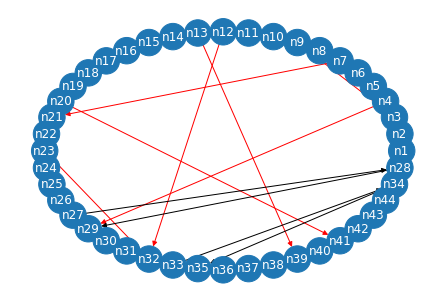

16:26:10 Fitness score: Lexicographic(32)

16:26:10     .file   "solution.c"
16:26:10     .text
16:26:10     .globl  _darwin
16:26:10     .def    _darwin;        .scl    2;      .type   32;     .endef
16:26:10 _darwin:
16:26:10 LFB17:
16:26:10     .cfi_startproc
16:26:10     pushl   %ebp
16:26:10     .cfi_def_cfa_offset 8
16:26:10     .cfi_offset 5, -8
16:26:10     movl    %esp, %ebp
16:26:10     .cfi_def_cfa_register 5
16:26:10 
16:26:10     movl	$-22690, %eax
16:26:10     movl	$-18761, %ebx
16:26:10     movl	$31143, %ecx
16:26:10     movl	$812, %edx
16:26:10 
16:26:10     jnz n9
16:26:10     jnz n28
16:26:10     sub %ebx, %eax
16:26:10     shl $202, %eax
16:26:10     jnz n21
16:26:10     shr $197, %ecx
16:26:10 n9:
16:26:10     and %eax, %edx
16:26:10     shl $89, %ecx
16:26:10     jnz n15
16:26:10     jno n31
16:26:10     ja n37
16:26:10     add %edx, %ecx
16:26:10 n15:
16:26:10     shl $228, %ecx
16:26:10     or %ebx, %eax
16:26:10     shr $47, %edx
16:26:10     add %eax, %ecx
16:2

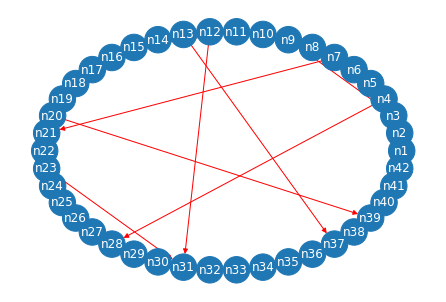

16:26:10 Fitness score: Lexicographic(32)

16:26:10     .file   "solution.c"
16:26:10     .text
16:26:10     .globl  _darwin
16:26:10     .def    _darwin;        .scl    2;      .type   32;     .endef
16:26:10 _darwin:
16:26:10 LFB17:
16:26:10     .cfi_startproc
16:26:10     pushl   %ebp
16:26:10     .cfi_def_cfa_offset 8
16:26:10     .cfi_offset 5, -8
16:26:10     movl    %esp, %ebp
16:26:10     .cfi_def_cfa_register 5
16:26:10 
16:26:10     movl	$-19651, %eax
16:26:10     movl	$20050, %ebx
16:26:10     movl	$-8468, %ecx
16:26:10     movl	$35, %edx
16:26:10 
16:26:10     jnz n9
16:26:10     jnz n28
16:26:10     sub %ebx, %eax
16:26:10     shl $202, %eax
16:26:10     jnz n21
16:26:10     shr $197, %ecx
16:26:10 n9:
16:26:10     and %eax, %edx
16:26:10     shl $89, %ecx
16:26:10     jnz n15
16:26:10     jno n31
16:26:10     ja n37
16:26:10     add %edx, %ecx
16:26:10 n15:
16:26:10     shl $228, %ecx
16:26:10     or %ebx, %eax
16:26:10     shr $47, %edx
16:26:10     add %eax, %ecx
16:26:

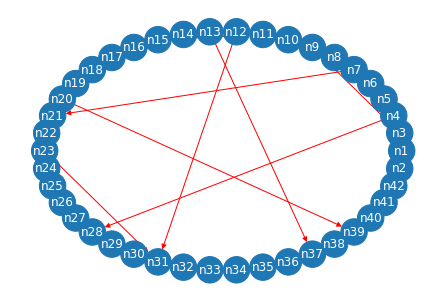

16:26:11 Fitness score: Lexicographic(32)

16:26:11     .file   "solution.c"
16:26:11     .text
16:26:11     .globl  _darwin
16:26:11     .def    _darwin;        .scl    2;      .type   32;     .endef
16:26:11 _darwin:
16:26:11 LFB17:
16:26:11     .cfi_startproc
16:26:11     pushl   %ebp
16:26:11     .cfi_def_cfa_offset 8
16:26:11     .cfi_offset 5, -8
16:26:11     movl    %esp, %ebp
16:26:11     .cfi_def_cfa_register 5
16:26:11 
16:26:11     movl	$-22690, %eax
16:26:11     movl	$-18761, %ebx
16:26:11     movl	$31143, %ecx
16:26:11     movl	$812, %edx
16:26:11 
16:26:11     jnz n9
16:26:11     jnz n30
16:26:11     sub %ebx, %eax
16:26:11     shl $69, %eax
16:26:11     jnz n22
16:26:11     shr $197, %ecx
16:26:11 n9:
16:26:11     and %eax, %edx
16:26:11     xor %ebx, %eax
16:26:11     shl $89, %ecx
16:26:11     jnz n16
16:26:11     jno n33
16:26:11     ja n39
16:26:11     add %edx, %ecx
16:26:11 n16:
16:26:11     shl $228, %ecx
16:26:11     or %ebx, %eax
16:26:11     shr $47, %edx
16:26

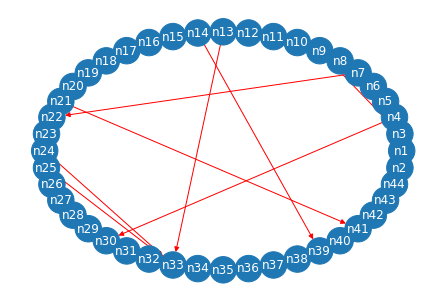

16:26:12 Fitness score: Lexicographic(32)

16:26:12     .file   "solution.c"
16:26:12     .text
16:26:12     .globl  _darwin
16:26:12     .def    _darwin;        .scl    2;      .type   32;     .endef
16:26:12 _darwin:
16:26:12 LFB17:
16:26:12     .cfi_startproc
16:26:12     pushl   %ebp
16:26:12     .cfi_def_cfa_offset 8
16:26:12     .cfi_offset 5, -8
16:26:12     movl    %esp, %ebp
16:26:12     .cfi_def_cfa_register 5
16:26:12 
16:26:12     movl	$-19651, %eax
16:26:12     movl	$20050, %ebx
16:26:12     movl	$-8468, %ecx
16:26:12     movl	$35, %edx
16:26:12 
16:26:12     jnz n9
16:26:12     jnz n28
16:26:12     sub %ebx, %eax
16:26:12     shl $69, %eax
16:26:12     jnz n21
16:26:12     shr $197, %ecx
16:26:12 n9:
16:26:12     and %eax, %edx
16:26:12     shl $89, %ecx
16:26:12     jnz n15
16:26:12     jno n33
16:26:12     ja n39
16:26:12     add %edx, %ecx
16:26:12 n15:
16:26:12     shl $228, %ecx
16:26:12     or %ebx, %eax
16:26:12     shr $47, %edx
16:26:12     add %eax, %ecx
16:26:1

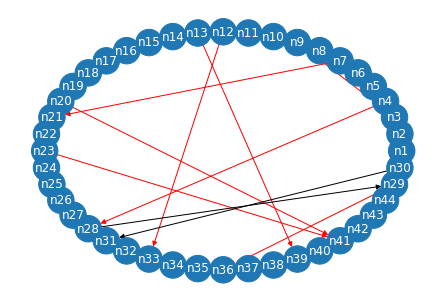

16:26:12 Fitness score: Lexicographic(32)

16:26:12     .file   "solution.c"
16:26:12     .text
16:26:12     .globl  _darwin
16:26:12     .def    _darwin;        .scl    2;      .type   32;     .endef
16:26:12 _darwin:
16:26:12 LFB17:
16:26:12     .cfi_startproc
16:26:12     pushl   %ebp
16:26:12     .cfi_def_cfa_offset 8
16:26:12     .cfi_offset 5, -8
16:26:12     movl    %esp, %ebp
16:26:12     .cfi_def_cfa_register 5
16:26:12 
16:26:12     movl	$-19651, %eax
16:26:12     movl	$20050, %ebx
16:26:12     movl	$-8468, %ecx
16:26:12     movl	$35, %edx
16:26:12 
16:26:12     jnz n9
16:26:12     jnz n28
16:26:12     sub %ebx, %eax
16:26:12     shl $69, %eax
16:26:12     jnz n21
16:26:12     shr $197, %ecx
16:26:12 n9:
16:26:12     and %eax, %edx
16:26:12     shl $89, %ecx
16:26:12     jnz n15
16:26:12     jno n31
16:26:12     ja n37
16:26:12     add %edx, %ecx
16:26:12 n15:
16:26:12     shl $228, %ecx
16:26:12     or %ebx, %eax
16:26:12     shr $47, %edx
16:26:12     add %eax, %ecx
16:26:1

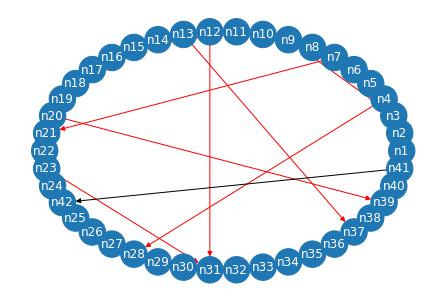

16:26:13 Fitness score: Lexicographic(32)

16:26:13     .file   "solution.c"
16:26:13     .text
16:26:13     .globl  _darwin
16:26:13     .def    _darwin;        .scl    2;      .type   32;     .endef
16:26:13 _darwin:
16:26:13 LFB17:
16:26:13     .cfi_startproc
16:26:13     pushl   %ebp
16:26:13     .cfi_def_cfa_offset 8
16:26:13     .cfi_offset 5, -8
16:26:13     movl    %esp, %ebp
16:26:13     .cfi_def_cfa_register 5
16:26:13 
16:26:13     movl	$-22690, %eax
16:26:13     movl	$-18761, %ebx
16:26:13     movl	$31143, %ecx
16:26:13     movl	$812, %edx
16:26:13 
16:26:13     jnz n9
16:26:13     jnz n28
16:26:13     sub %ebx, %eax
16:26:13     shl $69, %eax
16:26:13     jnz n21
16:26:13     shr $197, %ecx
16:26:13 n9:
16:26:13     and %eax, %edx
16:26:13     shl $89, %ecx
16:26:13     jnz n15
16:26:13     jno n31
16:26:13     ja n37
16:26:13     add %edx, %ecx
16:26:13 n15:
16:26:13     shl $228, %ecx
16:26:13     or %ebx, %eax
16:26:13     shr $47, %edx
16:26:13     add %eax, %ecx
16:26

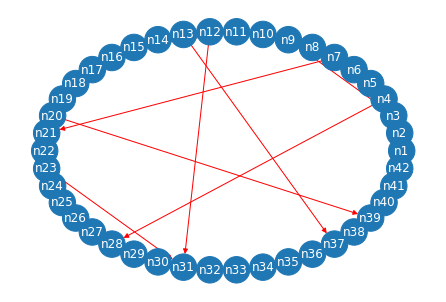

16:26:14 Fitness score: Lexicographic(32)

16:26:14     .file   "solution.c"
16:26:14     .text
16:26:14     .globl  _darwin
16:26:14     .def    _darwin;        .scl    2;      .type   32;     .endef
16:26:14 _darwin:
16:26:14 LFB17:
16:26:14     .cfi_startproc
16:26:14     pushl   %ebp
16:26:14     .cfi_def_cfa_offset 8
16:26:14     .cfi_offset 5, -8
16:26:14     movl    %esp, %ebp
16:26:14     .cfi_def_cfa_register 5
16:26:14 
16:26:14     movl	$-22690, %eax
16:26:14     movl	$-18761, %ebx
16:26:14     movl	$31143, %ecx
16:26:14     movl	$812, %edx
16:26:14 
16:26:14     jnz n9
16:26:14     jnz n29
16:26:14     sub %ebx, %eax
16:26:14     shl $69, %eax
16:26:14     jnz n21
16:26:14     shr $197, %ecx
16:26:14 n9:
16:26:14     and %eax, %edx
16:26:14     shl $89, %ecx
16:26:14     jnz n15
16:26:14     jno n32
16:26:14     ja n39
16:26:14     add %edx, %ecx
16:26:14 n15:
16:26:14     shl $228, %ecx
16:26:14     or %ebx, %eax
16:26:14     shr $47, %edx
16:26:14     add %eax, %ecx
16:26

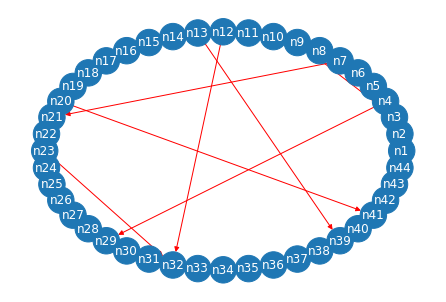

16:26:14 Fitness score: Lexicographic(32)



In [30]:
ugp.print_individual(darwin.archive.individuals,
                     msg="These are the best ever individuals:",
                     plot=True, score=True)